In [8]:
import pandas as pd
import os
from google.colab import drive
from scipy import stats
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/Psychologia/Magisterka/magisterka Psyche/Mateusz_Kamyczura_Praca_Magisterska/Praca Magisterska/Kody i Dane/Baza danych'
Output_path = path + '/Output'

Mounted at /content/drive


In [9]:
zasadyABC = pd.read_excel(Output_path + '/zasadyABC.xlsx')
zasadyXYZ = pd.read_excel(Output_path + '/zasadyXYZ.xlsx')

In [10]:
pewnoscABC = pd.read_excel(Output_path + '/pewnoscABC.xlsx')
pewnoscXYZ = pd.read_excel(Output_path + '/pewnoscXYZ.xlsx')

In [11]:

def wykres_rozkładu(df):
    # Sprawdzamy, czy kolumny istnieją w dataframe
    if 'CzyPoprawna' not in df.columns or 'OSAD' not in df.columns:
        print("Brak wymaganych kolumn w DataFrame!")
        return

    # Filtrowanie danych, aby uwzględnić tylko wiersze, gdzie CzyPoprawna == 1 lub CzyPoprawna == -1
    df = df[df['CzyPoprawna'].isin([1, -1])]

    # Grupujemy dane po 'CzyPoprawna'
    grupy = df.groupby('CzyPoprawna')

    # Tworzymy wykresy dla każdej z grup
    plt.figure(figsize=(11, 5))

    for idx, (value, grupa) in enumerate(grupy, 1):
        plt.subplot(1, 2, idx)
        sns.histplot(grupa['OSAD'], kde=True, bins=30, color='blue' if value == 1 else 'red')
        if (idx == 1):
            plt.title(f"Rozkład poziomu pewności wśród niepoprawnych odpowiedzi")
        else:
            plt.title(f"Rozkład poziomu pewności wśród poprawnych odpowiedzi")
        plt.xlabel('Poziom Pewności')
        plt.ylabel('Liczba obserwacji')

    # Wyświetlamy wykresy
    plt.tight_layout()
    plt.show()


def wykres_rozkładu_osad(df):
    # Sprawdzamy, czy kolumny istnieją w dataframe
    if 'G' not in df.columns or 'OSAD' not in df.columns:
        print("Brak wymaganych kolumn w DataFrame!")
        return

    # Filtrowanie danych, aby uwzględnić tylko wiersze, gdzie G == 0 lub G == 1
    df = df[df['G'].isin([0, 1])]

    # Grupujemy dane po 'G'
    grupy = df.groupby('G')

    # Tworzymy wykresy dla każdej z grup
    plt.figure(figsize=(11, 5))

    for idx, (value, grupa) in enumerate(grupy, 1):
        plt.subplot(1, 2, idx)
        sns.histplot(grupa['OSAD'], kde=True, bins=30, color='blue' if value == 1 else 'green')
        if (idx == 1):
            plt.title(f"Rozkład poziomu pewności wśród niegramatycznych pozycji")
        else:
            plt.title(f"Rozkład poziomu pewności wśród gramatycznych pozycji")
        plt.xlabel('Poziom Pewności')
        plt.ylabel('Liczba obserwacji')

    # Wyświetlamy wykresy
    plt.tight_layout()
    plt.show()

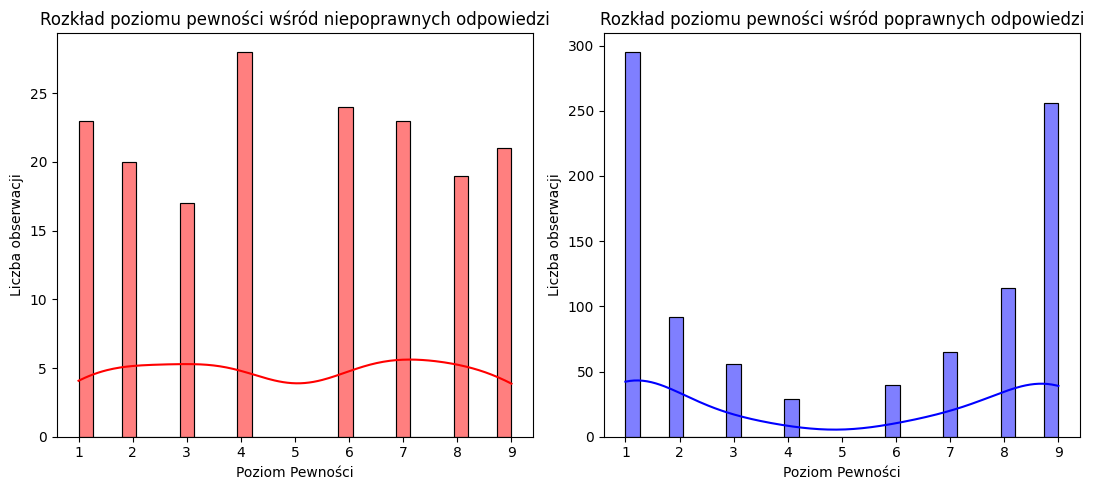

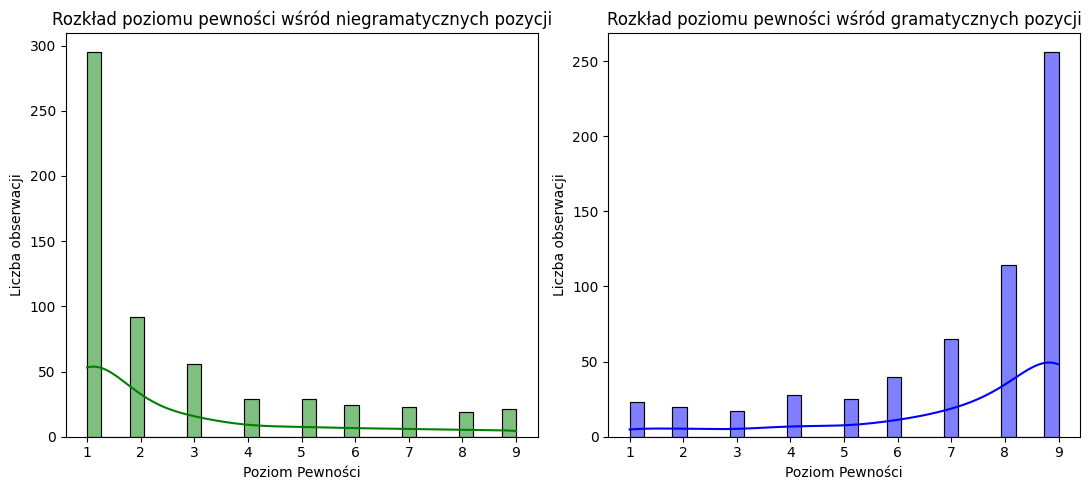

In [12]:

wykres_rozkładu(pewnoscABC)
wykres_rozkładu_osad(pewnoscABC)

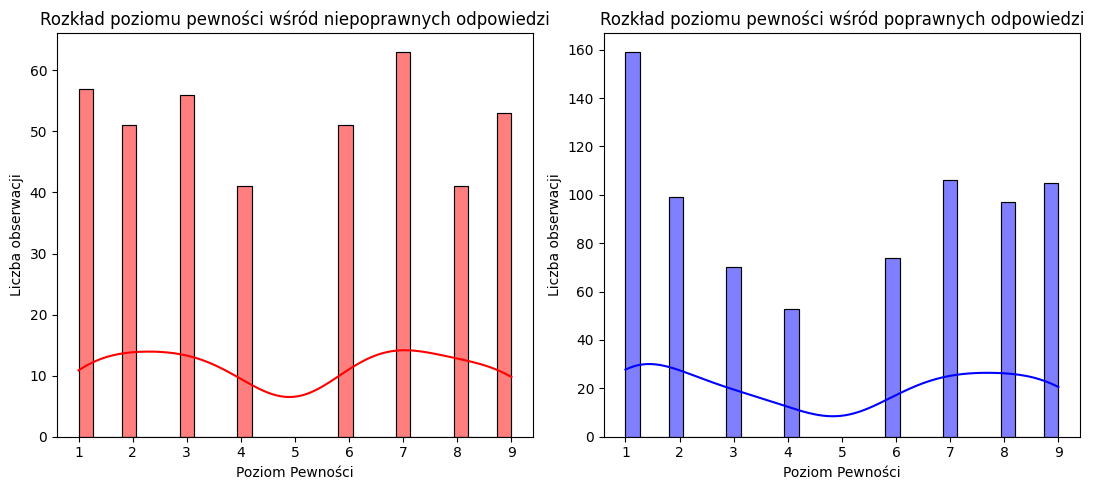

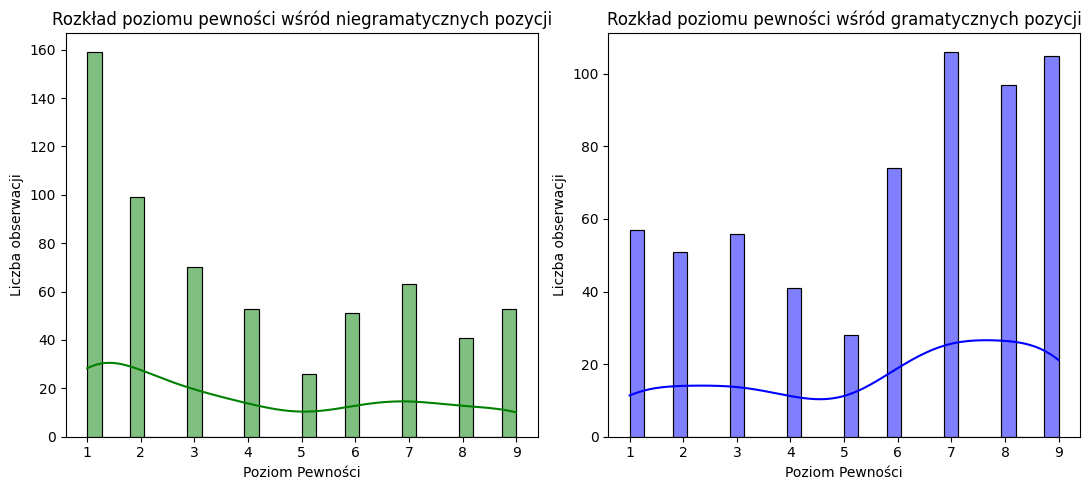

In [13]:

wykres_rozkładu(pewnoscXYZ)
wykres_rozkładu_osad(pewnoscXYZ)

In [14]:
def proporcja_gramatycznych_dla_kolumny_z_wykresem(df, kolumna_pewnosci):
    """
    Oblicza proporcję gramatycznych odpowiedzi (G=1) dla każdej wartości w podanej kolumnie pewności
    i rysuje wykres słupkowy z nałożoną linią regresji oraz wyświetla standaryzowaną betę (β)
    i odchylenia standardowe obu zmiennych.

    Parametry:
    df (pd.DataFrame): DataFrame zawierający kolumny 'G' oraz kolumnę z poziomem pewności.
    kolumna_pewnosci (str): Nazwa kolumny zawierającej poziomy pewności.

    Zwraca:
    pd.DataFrame: DataFrame z proporcjami i danymi dla regresji.
    """
    # Agregacja danych
    grouped = df.groupby(kolumna_pewnosci)['G'].agg(['count', 'sum'])
    #print(grouped)
    grouped.columns = ['Liczba_wszystkich', 'Liczba_gramatycznych']
    grouped['Proporcja_gramatycznych'] = grouped['Liczba_gramatycznych'] / grouped['Liczba_wszystkich']
    grouped = grouped.reset_index()
    wyniki_proporcji = grouped[[kolumna_pewnosci, 'Liczba_wszystkich', 'Liczba_gramatycznych', 'Proporcja_gramatycznych']]
    print(wyniki_proporcji)

    # Obliczanie SD dla interpretacji bety
    sd_x = wyniki_proporcji[kolumna_pewnosci].std()
    sd_y = wyniki_proporcji['Proporcja_gramatycznych'].std()

    # Regresja klasyczna (B)
    X = sm.add_constant(wyniki_proporcji[kolumna_pewnosci])
    y = wyniki_proporcji['Proporcja_gramatycznych']
    model = sm.OLS(y, X).fit()

    # Regresja na danych standaryzowanych (Beta)
    scaler = StandardScaler()
    X_std = scaler.fit_transform(wyniki_proporcji[[kolumna_pewnosci]])
    y_std = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
    X_std = sm.add_constant(X_std)
    model_std = sm.OLS(y_std, X_std).fit()

    # Pobieranie wartości bety i R²
    beta = model_std.params[1]
    beta_se = model_std.bse[1]
    r_squared = model.rsquared

    # Wyniki regresji
    print(f"\nWyniki regresji liniowej dla kolumny: {kolumna_pewnosci}")
    print(model.summary())
    print(f"\nStandaryzowana beta (β): {beta:.3f}, SE = {beta_se:.3f}, R² = {r_squared:.3f}")


    # Wykres słupkowy + regresja
    plt.figure(figsize=(10, 6))
    plt.bar(wyniki_proporcji[kolumna_pewnosci], wyniki_proporcji['Proporcja_gramatycznych'], color='skyblue', label='Proporcja gramatycznych')
    plt.plot(wyniki_proporcji[kolumna_pewnosci], model.predict(X), color='red', label=f'Regresja: y={model.params[1]:.2f}x + {model.params[0]:.2f}')
    plt.xlabel('Poziom Pewności')
    plt.ylabel('Proporcja odpowiedzi gramatycznych')
    plt.xticks(wyniki_proporcji[kolumna_pewnosci])
    plt.grid(axis='y', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return wyniki_proporcji


   OSAD  Liczba_wszystkich  Liczba_gramatycznych  Proporcja_gramatycznych
0     1                318                    23                 0.072327
1     2                112                    20                 0.178571
2     3                 73                    17                 0.232877
3     4                 57                    28                 0.491228
4     5                 54                    25                 0.462963
5     6                 64                    40                 0.625000
6     7                 88                    65                 0.738636
7     8                133                   114                 0.857143
8     9                277                   256                 0.924188

Wyniki regresji liniowej dla kolumny: OSAD
                               OLS Regression Results                              
Dep. Variable:     Proporcja_gramatycznych   R-squared:                       0.980
Model:                                 OLS   Adj

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)
<ipython-input-14-3298744975>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(wyniki_proporcji[kolumna_pewnosci], model.predict(X), color='red', label=f'Regresja: y={model.params[1]:.2f}x + {model.params[0]:.2f}')


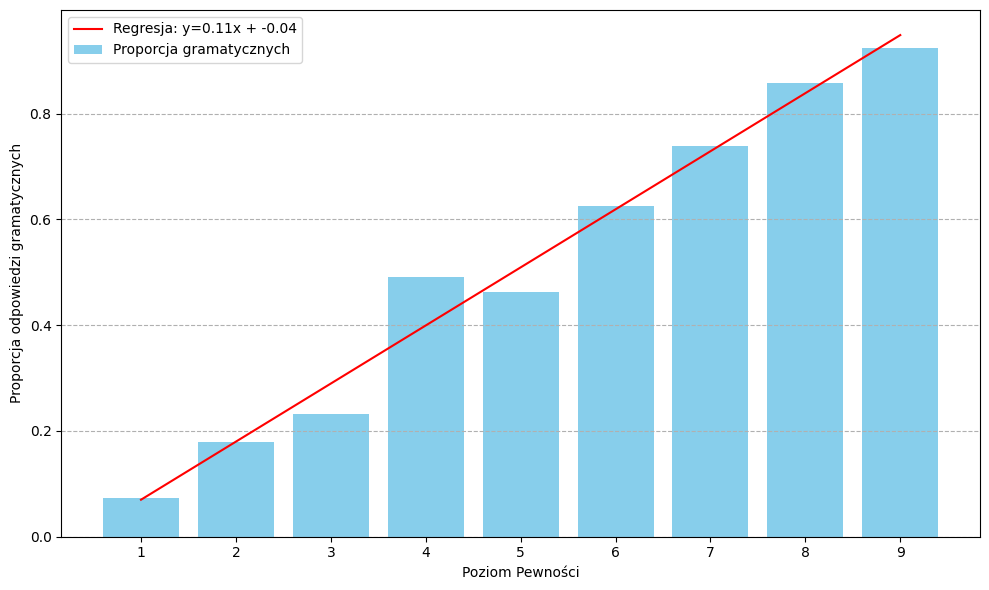

In [15]:
regABC = proporcja_gramatycznych_dla_kolumny_z_wykresem(pewnoscABC, 'OSAD')


   OSAD  Liczba_wszystkich  Liczba_gramatycznych  Proporcja_gramatycznych
0     1                216                    57                 0.263889
1     2                150                    51                 0.340000
2     3                126                    56                 0.444444
3     4                 94                    41                 0.436170
4     5                 54                    28                 0.518519
5     6                125                    74                 0.592000
6     7                169                   106                 0.627219
7     8                138                    97                 0.702899
8     9                158                   105                 0.664557

Wyniki regresji liniowej dla kolumny: OSAD
                               OLS Regression Results                              
Dep. Variable:     Proporcja_gramatycznych   R-squared:                       0.951
Model:                                 OLS   Adj

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)
<ipython-input-14-3298744975>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(wyniki_proporcji[kolumna_pewnosci], model.predict(X), color='red', label=f'Regresja: y={model.params[1]:.2f}x + {model.params[0]:.2f}')


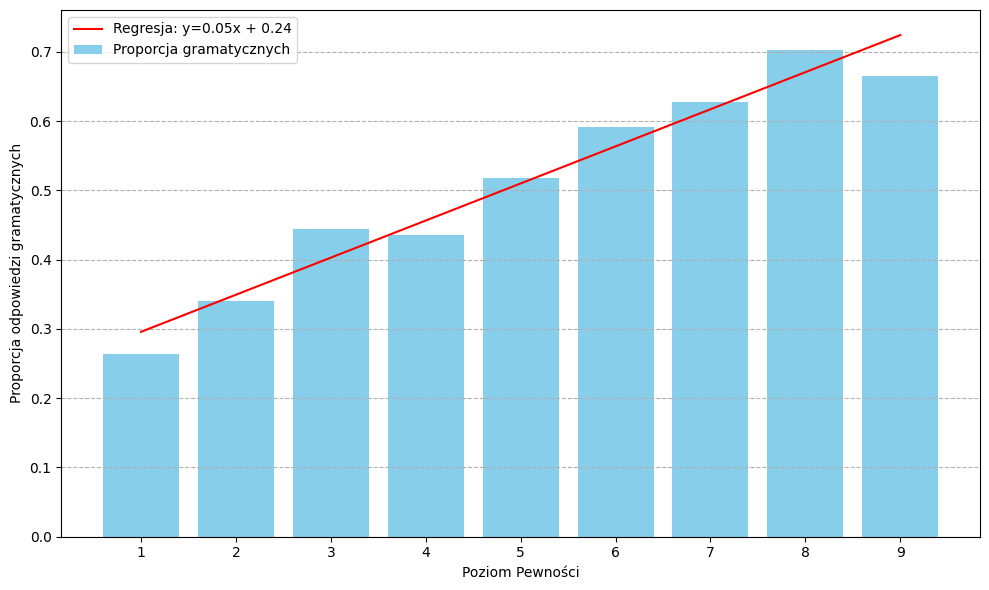

In [16]:
regXYZ = proporcja_gramatycznych_dla_kolumny_z_wykresem(pewnoscXYZ, 'OSAD')

In [17]:

def porownaj_dwie_regresje(df1, df2, kolumna_pewnosci):
    """
    Porównuje dwie regresje liniowe proporcji gramatycznych odpowiedzi względem poziomu pewności.

    Parametry:
    df1, df2 (pd.DataFrame): Dwa DataFrame'y zawierające kolumny 'G' (1 - gramatyczna, 0 - niegramatyczna)
                             oraz kolumnę z poziomem pewności.
    kolumna_pewnosci (str): Nazwa kolumny zawierającej poziomy pewności.

    Zwraca:
    pd.DataFrame, pd.DataFrame: Tabele z proporcjami dla każdej z grup.
    """
    def oblicz_proporcje(df):
        grouped = df.groupby(kolumna_pewnosci)['G'].agg(['count', 'sum'])
        grouped.columns = ['Liczba_wszystkich', 'Liczba_gramatycznych']
        grouped['Proporcja_gramatycznych'] = grouped['Liczba_gramatycznych'] / grouped['Liczba_wszystkich']
        return grouped.reset_index()

    wyniki1 = oblicz_proporcje(df1)
    wyniki2 = oblicz_proporcje(df2)

    # Regresja dla obu grup
    X1 = sm.add_constant(wyniki1[kolumna_pewnosci])
    y1 = wyniki1['Proporcja_gramatycznych']
    model1 = sm.OLS(y1, X1).fit()

    X2 = sm.add_constant(wyniki2[kolumna_pewnosci])
    y2 = wyniki2['Proporcja_gramatycznych']
    model2 = sm.OLS(y2, X2).fit()

    # Wyświetlenie wyników regresji
    print("\n--- Regresja dla Modelu ABC ---")
    print(model1.summary())
    print("\n--- Regresja dla Modelu XYZ ---")
    print(model2.summary())

    # Porównanie nachyleń
    b1, se1 = model1.params[1], model1.bse[1]
    b2, se2 = model2.params[1], model2.bse[1]
    t_stat = (b1 - b2) / ((se1**2 + se2**2)**0.5)
    df = len(df1) + len(df2) - 4  # przybliżone df
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=df))

    # Obliczenie wielkości efektu d Cohena (przybliżenie)
    d_cohen = (2 * abs(t_stat)) / (df ** 0.5)

    print(f"\nPorównanie nachyleń:")
    print(f"Nachylenie Model ABC: {b1:.4f}, SE: {se1:.4f}")
    print(f"Nachylenie Model XYZ: {b2:.4f}, SE: {se2:.4f}")
    print(f"T-statystyka: {t_stat:.4f}, p-value: {p_value:.4f}")
    print(f"Wielkość efektu (d Cohena) dla różnicy nachyleń: {d_cohen:.4f}")

    # Wykres
    plt.figure(figsize=(10, 6))
    plt.bar(wyniki1[kolumna_pewnosci]-0.2, wyniki1['Proporcja_gramatycznych'], width=0.4, label='Model ABC', color='skyblue')
    plt.bar(wyniki2[kolumna_pewnosci]+0.2, wyniki2['Proporcja_gramatycznych'], width=0.4, label='Model XYZ', color='orange')
    plt.plot(wyniki1[kolumna_pewnosci], model1.predict(X1), color='blue', linestyle='--', label=f'Model ABC: y={b1:.2f}x + {model1.params[0]:.2f}')
    plt.plot(wyniki2[kolumna_pewnosci], model2.predict(X2), color='red', linestyle='--', label=f'Model XYZ: y={b2:.2f}x + {model2.params[0]:.2f}')
    plt.xlabel('Poziom Pewności')
    plt.ylabel('Poziom skuteczności')
    #plt.title('Porównanie dwóch regresji liniowych')
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    return wyniki1, wyniki2



--- Regresja dla Modelu ABC ---
                               OLS Regression Results                              
Dep. Variable:     Proporcja_gramatycznych   R-squared:                       0.980
Model:                                 OLS   Adj. R-squared:                  0.977
Method:                      Least Squares   F-statistic:                     340.9
Date:                     Tue, 10 Jun 2025   Prob (F-statistic):           3.39e-07
Time:                             18:09:38   Log-Likelihood:                 16.059
No. Observations:                        9   AIC:                            -28.12
Df Residuals:                            7   BIC:                            -27.72
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)
<ipython-input-17-1764766753>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b1, se1 = model1.params[1], model1.bse[1]
<ipython-input-17-1764766753>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior).

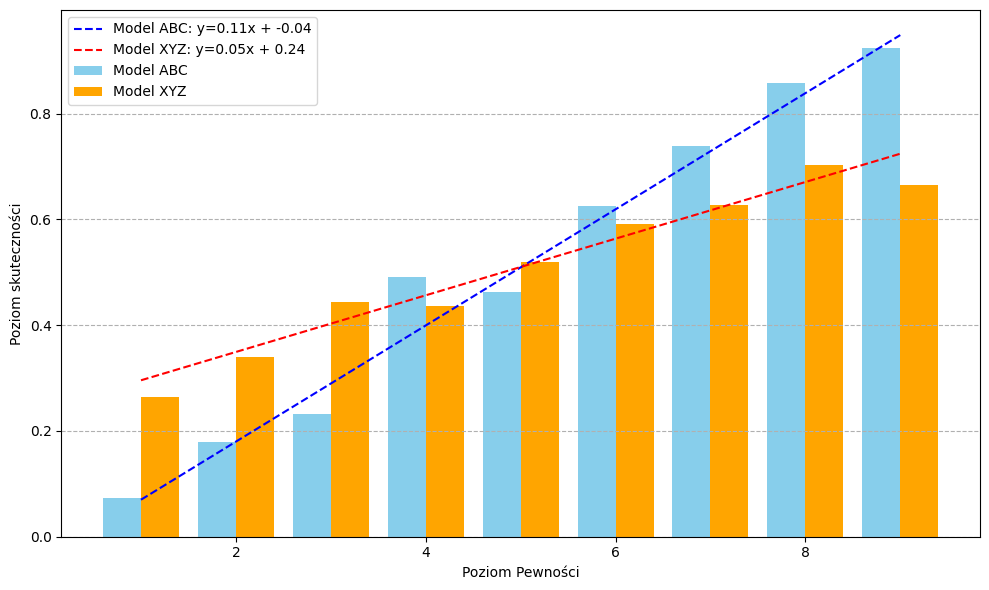

(   OSAD  Liczba_wszystkich  Liczba_gramatycznych  Proporcja_gramatycznych
 0     1                318                    23                 0.072327
 1     2                112                    20                 0.178571
 2     3                 73                    17                 0.232877
 3     4                 57                    28                 0.491228
 4     5                 54                    25                 0.462963
 5     6                 64                    40                 0.625000
 6     7                 88                    65                 0.738636
 7     8                133                   114                 0.857143
 8     9                277                   256                 0.924188,
    OSAD  Liczba_wszystkich  Liczba_gramatycznych  Proporcja_gramatycznych
 0     1                216                    57                 0.263889
 1     2                150                    51                 0.340000
 2     3                

In [18]:
porownaj_dwie_regresje(pewnoscABC, pewnoscXYZ, 'OSAD')

In [19]:
def moderacja_bootstrap(regABC, regXYZ, kolumna_pewnosci='OSAD', trafnosc='Proporcja_gramatycznych', n_boot=1000, seed=36):
    """
    Wykonuje analizę moderacji z użyciem bootstrappingu na danych z dwóch modeli (regABC i regXYZ).
    Zakłada, że obie ramki mają te same kolumny: poziom pewności i trafność.

    Parametry:
    - regABC, regXYZ: DataFrame'y z kolumnami: poziom pewności i proporcja trafności.
    - kolumna_pewnosci: nazwa kolumny z poziomem pewności.
    - trafnosc: nazwa kolumny z trafnością (proporcja gramatycznych).
    - n_boot: liczba prób bootstrapowych.
    - seed: random seed (dla powtarzalności).

    Zwraca:
    - Średnia interakcja, 95% CI, p-value (empiryczne)
    """

    np.random.seed(seed)
    interakcje = []

    # scal dane z info o modelu
    regABC_ = regABC.copy()
    regABC_['model'] = 'ABC'
    regXYZ_ = regXYZ.copy()
    regXYZ_['model'] = 'XYZ'

    full_df = pd.concat([regABC_, regXYZ_], ignore_index=True)

    for _ in range(n_boot):
        boot = full_df.sample(frac=1, replace=True)
        model = smf.ols(f'{trafnosc} ~ {kolumna_pewnosci} * model', data=boot).fit()

        # nazwa interakcji może się różnić w zależności od porządku sortowania kategorii
        try:
            b_interakcja = model.params[f'{kolumna_pewnosci}:model[T.XYZ]']
        except KeyError:
            b_interakcja = model.params[[k for k in model.params.keys() if ':' in k][0]]  # fallback

        interakcje.append(b_interakcja)

    interakcje = np.array(interakcje)
    ci_lower = np.percentile(interakcje, 2.5)
    ci_upper = np.percentile(interakcje, 97.5)
    mean_inter = np.mean(interakcje)
    if mean_inter > 0:
        p_empiryczne = 2 * np.mean(interakcje <= 0)
    else:
        p_empiryczne = 2 * np.mean(interakcje >= 0)

    print("🔍 Wyniki moderacji z bootstrappingiem:")
    print(f"• Średnia wartość interakcji (β moderacji): {mean_inter:.4f}")
    print(f"• 95% przedział ufności: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"• Empiryczne p-value: {p_empiryczne:.4f}")




In [20]:
moderacja_bootstrap(regABC, regXYZ)

🔍 Wyniki moderacji z bootstrappingiem:
• Średnia wartość interakcji (β moderacji): -0.0564
• 95% przedział ufności: [-0.0751, -0.0417]
• Empiryczne p-value: 0.0020
